### 0. Imports 

In [ ]:
# read in data from tiingo
from pandas_datareader import data as pdr
# basic dataframe and array manipulation
import numpy as np              
import pandas as pd             
from datetime import datetime
# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
# keras sequential model pipeline
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, ConvLSTM1D, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.utils import plot_model
# for GridSearch CV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
# for timing training
import timeit
# plotting results: formating x axis date
import matplotlib.dates as mdates

In [ ]:
# get spy data from tiingo
with open('credentials/tiingo','r') as f:
    TIINGO_API_KEY = f.read().strip()
# get train data, 6 year
start=datetime(2010, 1, 1)  # start day
end=datetime(2016, 12, 31)  # end day
train_data = pdr.DataReader(["AAPL"], 'tiingo', start, end, api_key = TIINGO_API_KEY).loc["AAPL"]
# get test data, 3 year, skipping covid boom period (2020 spring)
start=datetime(2017, 1, 1)  # start day
end=datetime(2019, 12, 31)  # end day
val_data = pdr.DataReader(["AAPL"], 'tiingo', start, end, api_key = TIINGO_API_KEY).loc["AAPL"]
# get test data, 3 year, skipping covid boom period (2020 spring)
start=datetime(2020, 5, 1)  # start day
end=datetime(2023, 5, 1)  # end day 
test_data = pdr.DataReader(["AAPL"], 'tiingo', start, end, api_key = TIINGO_API_KEY).loc["AAPL"]

### 1. Data Preprocessing

In [ ]:
window_size = 14
def window_data(df, window_size):
    X = []
    y = []
    for i in range(1 , len(df) - window_size -1 , 1):
        first = df.iloc[i,2]
        temp = []
        temp2 = []
        for j in range(window_size):
            temp.append((df.iloc[i + j, 2] - first) / first)
        temp2.append((df.iloc[i + window_size, 2] - first) / first)
        X.append(np.array(temp).reshape(window_size, 1))
        y.append(np.array(temp2).reshape(1, 1))
    return X, y

X_train, y_train = window_data(train_data, window_size)
X_val, y_val = window_data(val_data, window_size)
X_test, y_test = window_data(test_data, window_size)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

X_train = X_train.reshape(X_train.shape[0],1,window_size,1)
X_val = X_val.reshape(X_val.shape[0],1,window_size,1)
X_test = X_test.reshape(X_test.shape[0],1,window_size,1)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1746, 1, 14, 1)
(738, 1, 14, 1)
(739, 1, 14, 1)


### 2. Model construction 

#### &ensp;&ensp;&ensp;&ensp; 2.a Baseline model: FC-LSTM 

#### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; 2.a.(i) Hyperparameter Tuning

In [ ]:
def create_fc_lstm(dropout_rate=0.5, recurrent_dropout=0.5, lstm_units = 64):
    model = tf.keras.Sequential()
    model.add(LSTM(lstm_units, recurrent_dropout=recurrent_dropout, return_sequences=True,
                   input_shape=(window_size, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, recurrent_dropout=recurrent_dropout,activation='relu', return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, recurrent_dropout=recurrent_dropout,activation='relu', return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])
    return model
# GridSearch CV
param_grid = {
    'dropout_rate': [0.3, 0.5],
    'recurrent_dropout' :[0.3, 0.5],
    'lstm_units': [32, 64, 128],
}
# create KerasRegressor and GridSearchCV objects
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
tf.keras.backend.clear_session()
model = KerasRegressor(build_fn=create_fc_lstm, epochs=100, batch_size=32, 
                       verbose=0, callbacks=[early_stopping])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0)

# perform Grid Search CV
grid_result = grid.fit(X_train.reshape((len(X_train), X_train.shape[2], X_train.shape[3])),y_train,
                       validation_data=(X_val.reshape((len(X_val), X_val.shape[2], X_val.shape[3])),y_val))
fc_lstm_best_params = grid_result.best_params_

# print results
print(f"Best params: {grid_result.best_params_}")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best params: {'dropout_rate': 0.3, 'lstm_units': 128, 'recurrent_dropout': 0.3}


#### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; 2.a.(ii) Training the model

In [ ]:
tf.keras.backend.clear_session()
fc_lstm = create_fc_lstm(dropout_rate=fc_lstm_best_params['dropout_rate'],
                         recurrent_dropout=fc_lstm_best_params['recurrent_dropout'], 
                         lstm_units = fc_lstm_best_params['lstm_units'])
fc_lstm._name = "FC-LSTM"
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
fc_lstm.summary()

Model: "FC-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 14, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 14, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 14, 128)           0         
                                                                 
 flatten (Flatten)           (None, 1792)              0   

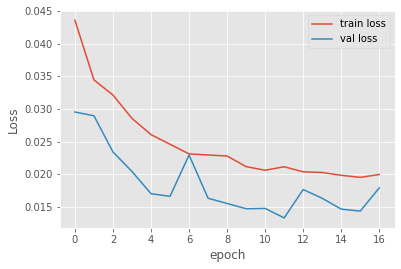

In [ ]:
start_time = timeit.default_timer()
fc_lstm_history = fc_lstm.fit(X_train.reshape((len(X_train), X_train.shape[2], X_train.shape[3])),y_train, 
                              validation_data=(X_val.reshape((len(X_val), X_val.shape[2], X_val.shape[3])),y_val), 
                                               epochs=100,batch_size=32, verbose=0, callbacks=[early_stopping])
fc_lstm_elapsed = timeit.default_timer() - start_time
plt.plot(fc_lstm_history.history['loss'], label='train loss')
plt.plot(fc_lstm_history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

#### &ensp;&ensp;&ensp;&ensp; 2.b CNN-LSTM 

#### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; 2.b.(i) Hyperparameter tuning

In [ ]:
# Use Grid Search to Tune drop out 
def create_cnn_lstm(dropout_rate=0.5, recurrent_dropout=0.5, cnn_units=[32, 64, 128], 
                    lstm_units = 64, kernel_size=5):
    model = tf.keras.Sequential()
    # CNN layers
    model.add(TimeDistributed(Conv1D(cnn_units[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=(None, window_size, 1))))
    model.add(TimeDistributed(Conv1D(cnn_units[1], kernel_size=kernel_size, activation='relu')))
    model.add(TimeDistributed(Conv1D(cnn_units[2], kernel_size=kernel_size, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))
    # cnn_lstm.add(Dense(5, kernel_regularizer=L2(0.01)))
    # LSTM layers
    model.add(LSTM(lstm_units, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, recurrent_dropout=recurrent_dropout, return_sequences=False))
    model.add(Dropout(dropout_rate))
    # FC layers, output
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])
    return model
# GridSearch CV
param_grid = {
    'dropout_rate': [0.3, 0.5],
    'recurrent_dropout' :[0.3, 0.5],
    'cnn_units': [[32, 64, 128], [64, 64, 128]],
    'lstm_units': [32, 64, 128],
    'kernel_size': [3, 5]
}
# create KerasRegressor and GridSearchCV objects
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
tf.keras.backend.clear_session()
model = KerasRegressor(build_fn=create_cnn_lstm, epochs=100, batch_size=32, 
                       verbose=0, callbacks=[early_stopping])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0)

# perform Grid Search CV
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))
cnn_lstm_best_params = grid_result.best_params_

# print results
print(f"Best params: {grid_result.best_params_}")

<ipython-input-12-be7f2ccfb87d>:35: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_cnn_lstm, epochs=100, batch_size=32,


Best params: {'cnn_units': [32, 64, 128], 'dropout_rate': 0.3, 'kernel_size': 3, 'lstm_units': 128, 'recurrent_dropout': 0.5}


#### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; 2.b.(ii) Training the model

In [ ]:
tf.keras.backend.clear_session()
cnn_lstm = create_cnn_lstm(dropout_rate=cnn_lstm_best_params['dropout_rate'], 
                           recurrent_dropout=cnn_lstm_best_params['recurrent_dropout'],
                           cnn_units=cnn_lstm_best_params['cnn_units'], 
                           lstm_units=cnn_lstm_best_params['lstm_units'], 
                           kernel_size=cnn_lstm_best_params['kernel_size'])
cnn_lstm._name = "CNN-LSTM"
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
cnn_lstm.build(input_shape=(len(X_train),None, window_size, 1))
cnn_lstm.summary()

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1746, None, 12, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1746, None, 10, 64)     6208      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1746, None, 8, 128)     24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1746, None, 4, 128)     0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (1746, None, 512)        0  

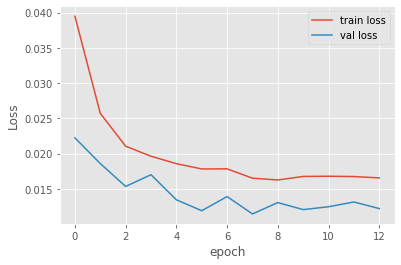

In [ ]:
start_time = timeit.default_timer()
cnn_lstm_history = cnn_lstm.fit(X_train, y_train, validation_data=(X_val,y_val), 
                    epochs=100,batch_size=32, verbose=0, callbacks=[early_stopping])
cnn_lstm_elapsed = timeit.default_timer() - start_time
plt.plot(cnn_lstm_history.history['loss'], label='train loss')
plt.plot(cnn_lstm_history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

#### &ensp;&ensp;&ensp;&ensp; 2.c ConVLSTM

#### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; 2.c.(i) Hyperparameter tuning

In [ ]:
def create_convlstm(dropout_rate=0.5, recurrent_dropout=0.5, units=[64,64,128], kernel_size=5):
    model = tf.keras.Sequential()
    model.add(ConvLSTM1D(filters=units[0], recurrent_dropout=recurrent_dropout, kernel_size=kernel_size, 
                         padding="same", input_shape=(None, window_size, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(ConvLSTM1D(filters=units[1], recurrent_dropout=recurrent_dropout, kernel_size=kernel_size, 
                         padding="same", return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(ConvLSTM1D(filters=units[2], recurrent_dropout=recurrent_dropout, kernel_size=kernel_size, 
                         padding="same", return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae'])
    return model
# GridSearch CV
param_grid = {
    'dropout_rate': [0.3, 0.5],
    'recurrent_dropout' :[0.3, 0.5],
    'units': [[128, 64, 32],[32, 64, 128],[64, 64, 64]],
    'kernel_size': [3, 5]
}
# create KerasRegressor and GridSearchCV objects
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
model = KerasRegressor(build_fn=create_convlstm, epochs=100, batch_size=32, 
                       verbose=0, callbacks=[early_stopping])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0)

# perform Grid Search CV
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))
convlstm_best_params = grid_result.best_params_

# print results
print(f"Best params: {grid_result.best_params_}")

<ipython-input-15-e965e00549af>:25: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_convlstm, epochs=100, batch_size=32,


Best params: {'dropout_rate': 0.3, 'kernel_size': 5, 'recurrent_dropout': 0.5, 'units': [128, 64, 32]}


#### &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; 2.c.(ii) Training the model

In [ ]:
tf.keras.backend.clear_session()
convlstm = create_convlstm(dropout_rate=convlstm_best_params['dropout_rate'],
                           recurrent_dropout=convlstm_best_params['recurrent_dropout'],
                           units=convlstm_best_params['units'], 
                           kernel_size=convlstm_best_params['kernel_size'])
convlstm._name = "ConVLSTM"
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
convlstm.build(input_shape=(len(X_train),None, 30, 1))
convlstm.summary()

Model: "ConVLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, None, 14, 128)     330752    
                                                                 
 dropout (Dropout)           (None, None, 14, 128)     0         
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, None, 14, 64)      246016    
                                                                 
 dropout_1 (Dropout)         (None, None, 14, 64)      0         
                                                                 
 conv_lstm1d_2 (ConvLSTM1D)  (None, 14, 32)            61568     
                                                                 
 dropout_2 (Dropout)         (None, 14, 32)            0         
                                                                 
 flatten (Flatten)           (None, 448)               0  

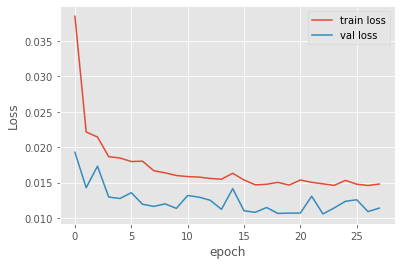

In [ ]:
start_time = timeit.default_timer()
convlstm_history = convlstm.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=100,
                                batch_size=32, verbose=0, callbacks=[early_stopping])
convlstm_elapsed = timeit.default_timer() - start_time
plt.plot(convlstm_history.history['loss'], label='train loss')
plt.plot(convlstm_history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

### 3. Testing Phase

In [ ]:
def plot_stock_prediction(window,model,X_test):
    test_result = model.evaluate(X_test, y_test)
    predicted = model.predict(X_test)
    true_Y = test_data['low'].iloc[(window+1):-1]
    true_Y_prev = test_data['low'].iloc[1:-1-window]
    df_test_time = true_Y.index.date
    pred_Y = (np.array(predicted[:,0])*true_Y_prev)+true_Y_prev
    print("R2 score of ",model._name,": ",r2_score(y_test.reshape(-1,1), predicted))
    # plot test data
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(30, 8))
    monthly_locator = mdates.MonthLocator()
    half_year_locator = mdates.MonthLocator(interval=1)
    year_month_formatter = mdates.DateFormatter("%Y-%m")
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_minor_locator(monthly_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    ax.plot(np.array(df_test_time), true_Y,color = 'red', label = 'Real Stock Price')
    ax.plot(np.array(df_test_time), pred_Y,color = 'green', label = 'Predicted Stock Price')
    ax.title.set_text(f'Stock Price Prediction, \
    MAE = \$ {round(float(mean_absolute_error(pred_Y,true_Y)),8)}, \
    MSE = \$ {round(float(mean_squared_error(true_Y,pred_Y)),8)}')
    ax.legend(loc='upper left')
    fig.autofmt_xdate()

#### &ensp;&ensp;&ensp;&ensp; 3.a FC-LSTM 

24/24 [==============================] - 1s 34ms/step
R2 score of  FC-LSTM :  0.8740441414805302


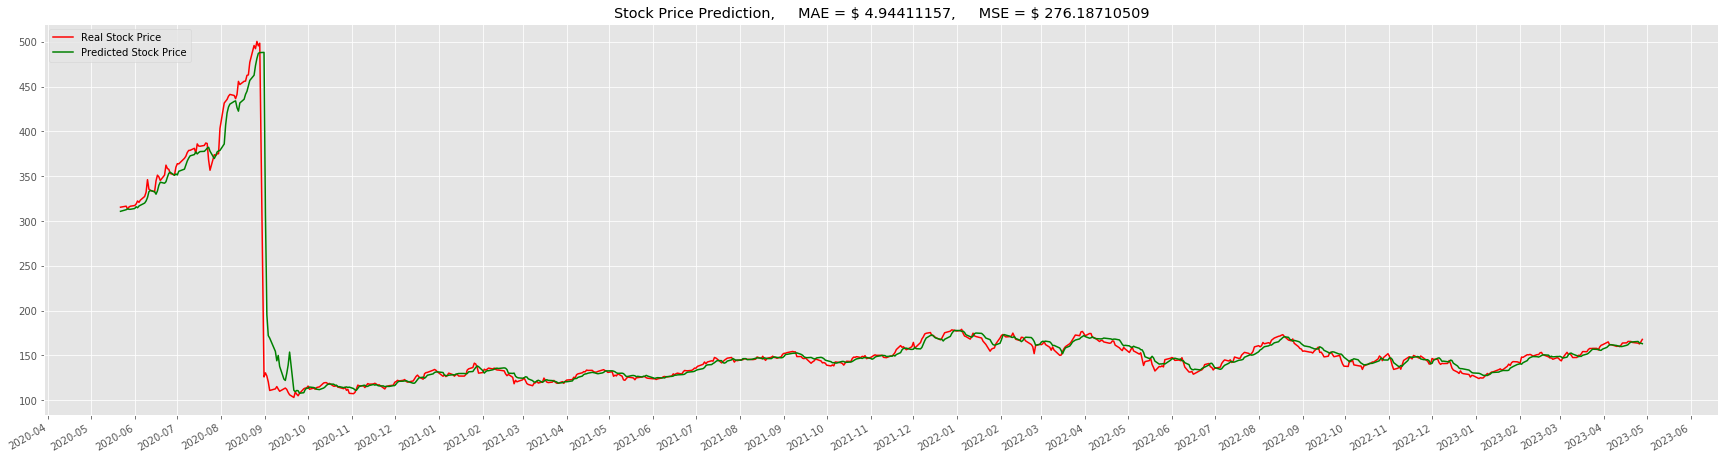

In [ ]:
plot_stock_prediction(window_size,fc_lstm,X_test.reshape((len(X_test), X_test.shape[2], X_test.shape[3])))

In [ ]:
print("Model training time:",fc_lstm_elapsed)

Model training time: 94.75706969799921


#### &ensp;&ensp;&ensp;&ensp; 3.b CNN-LSTM 

24/24 [==============================] - 0s 10ms/step
R2 score of  CNN-LSTM :  0.9139324437237274


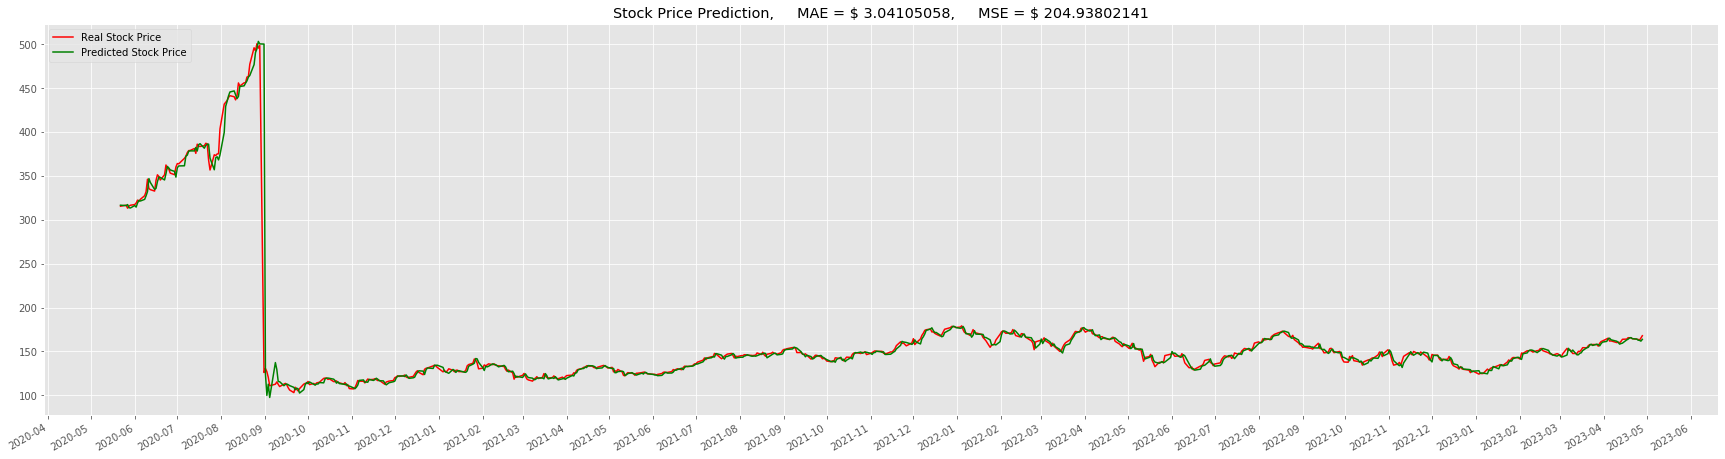

In [ ]:
plot_stock_prediction(window_size,cnn_lstm,X_test)

In [ ]:
print("Model training time:",cnn_lstm_elapsed)

Model training time: 35.57562987100005


#### &ensp;&ensp;&ensp;&ensp; 3.c ConVLSTM 

24/24 [==============================] - 1s 31ms/step
R2 score of  ConVLSTM :  0.9177376534570053


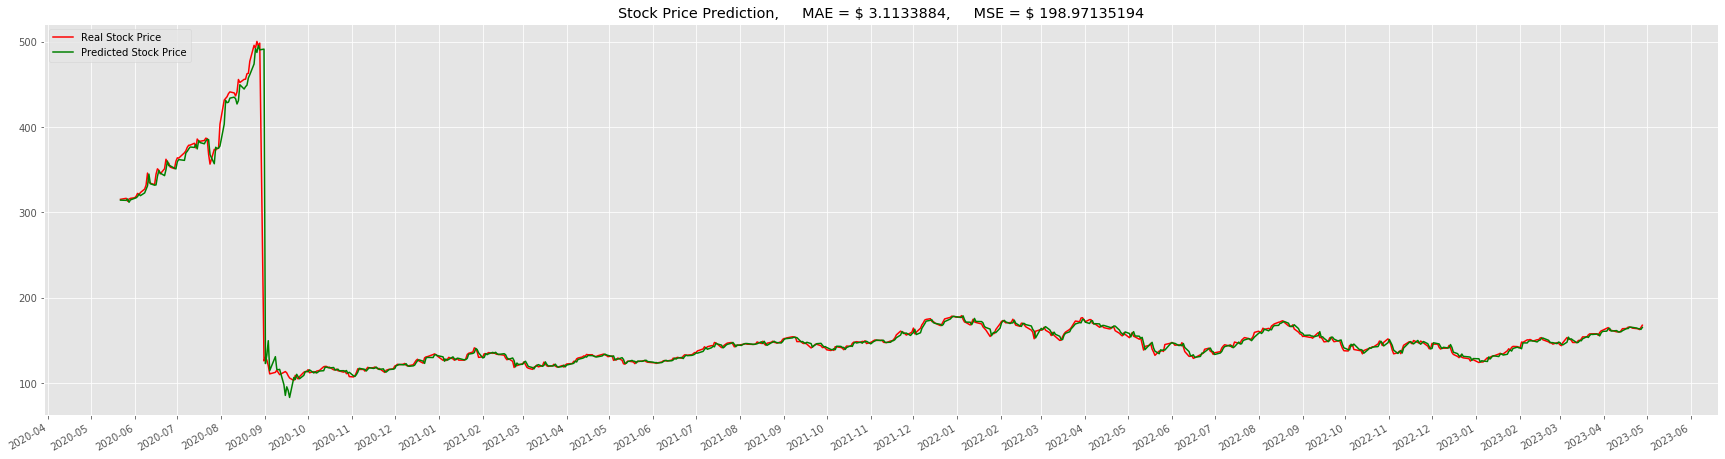

In [ ]:
plot_stock_prediction(window_size,convlstm,X_test)

In [ ]:
print("Model training time:",convlstm_elapsed)

Model training time: 161.20439217799958
